<a href="https://colab.research.google.com/github/battistabiggio/ai4dev/blob/main/notebooks/AI4Dev_06_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks (and some other tricks)

In this notebook, we will see how to implement a convolutional neural network in PyTorch. These models use discrete convolutions to process the images. 

With deep learning, we can combine convolutions and downsampling to extract higher-level information from the images. The goal is to **learn** the best filters to extract features that lead to lower loss values.

This time we will use the CIFAR10 dataset, composed of RGB images (3 channels) of size $32 \times 32$

Note that we specify the number of input channels and the number of output channels. Additionally, there are parameters that affect the dimension of the filter and further processing on the convolutions.

After each filter, the size of each channel in the output is determined by:

$$
Z = \frac{W - K + 2P}{S} + 1
$$

* W = width of the image (consider square images)
* K = kernel size (also square)
* P = padding (to frame the image, usually so that we can make this ratio an integer)

Layer math for our network:

$$
Z = \frac{W - K + 2P}{S} + 1
$$

* Input `(batch_size, 3, 32, 32)`
* Conv layer, `in_channels=3`, `K=3`, `P=1`, `out_channels=16`
  * output = 16 channels of of width and height $\frac{32 - 3 + 2(1)}{1} + 1 = 32$
* MaxPool, `K=2` -> output = 16 channels of size $\frac{32}{2} = 16$
* Conv layer, `in_channels=16`, `K=3`, `P=1`, `out_channels=8`
  * output = 8 channels of of width and height $\frac{16 - 3 + 2(1)}{1} + 1 = 16$
* MaxPool, `K=2`
  * output = 8 channels of width and height $\frac{16}{2} = 8$
* Linear (fully-connected) Layer of input size $w \times h \times c = 8 \times 8 \times 8$ and $32$ output units
* Linear (fully-connected) Layer of input size $32$ and output $10$ as the $10$ output classes


In [1]:
import torch
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)  # see layer math above
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

We can load the CIFAR10 dataset from torchvision, similarly to what we did with the MNIST dataset.

In [2]:
from torchvision import datasets, transforms

transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))  # mean and std for CIFAR10
])

data_path = 'data'
cifar_train = datasets.CIFAR10(data_path,
                             train=True,
                             download=True,
                               transform=transf)
cifar_validation = datasets.CIFAR10(data_path,
                                  train=False,
                                  download=True, transform=transf)

print("samples in training dataset: ", len(cifar_train))

Files already downloaded and verified
Files already downloaded and verified
samples in training dataset:  50000


In [3]:
train_loader = torch.utils.data.DataLoader(cifar_train,
                                           batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar_validation,
                                         batch_size=64,
                                         shuffle=False)

And we can finally write the training loop. We are going to use a function for the training epochs and one for the validation epochs, and additionally we can track the loss values to inspect them later.

In [4]:
learning_rate = 1e-2
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net()
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
loss_fn = torch.nn.CrossEntropyLoss()


def train_epoch(model, train_loader, optimizer, scheduler, loss_fn):
    model.train()
    train_loss = 0.0
    total = 0
    for samples, labels in train_loader:
        samples, labels = samples.to(device), labels.to(device)
        outputs = model(samples)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += samples.shape[0]
        train_loss += loss.sum().detach()
    train_loss /= total
    scheduler.step()
    return train_loss.item()

def valid_epoch(model, val_loader, loss_fn):
    model.eval()
    accuracy = 0.0
    validation_loss = 0.0
    total = 0
    for samples, labels in val_loader:
        samples, labels = samples.to(device), labels.to(device)
        outputs = net(samples)
        loss = loss_fn(outputs, labels)
        predictions = outputs.argmax(dim=1)
        accuracy += (predictions.type(labels.dtype) == labels).float().sum()
        total += samples.shape[0]
        validation_loss += loss.sum()
    validation_loss /= total
    accuracy = accuracy / total
    return validation_loss.item(), accuracy.item()

train_losses, val_losses, accuracies = [], [], []
for epoch in range(epochs):
    train_loss = train_epoch(net, train_loader, optimizer, scheduler, loss_fn)
    val_loss, accuracy = valid_epoch(net, val_loader, loss_fn)
    print(f"epoch: {epoch}, validation accuracy: {accuracy}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)

epoch: 0, validation accuracy: 0.2773999869823456
epoch: 1, validation accuracy: 0.35530000925064087
epoch: 2, validation accuracy: 0.39989998936653137
epoch: 3, validation accuracy: 0.4320000112056732
epoch: 4, validation accuracy: 0.4790000021457672
epoch: 5, validation accuracy: 0.5253999829292297
epoch: 6, validation accuracy: 0.5411999821662903
epoch: 7, validation accuracy: 0.5241000056266785
epoch: 8, validation accuracy: 0.5501000285148621
epoch: 9, validation accuracy: 0.5317999720573425


Let's now plot the values we tracked:

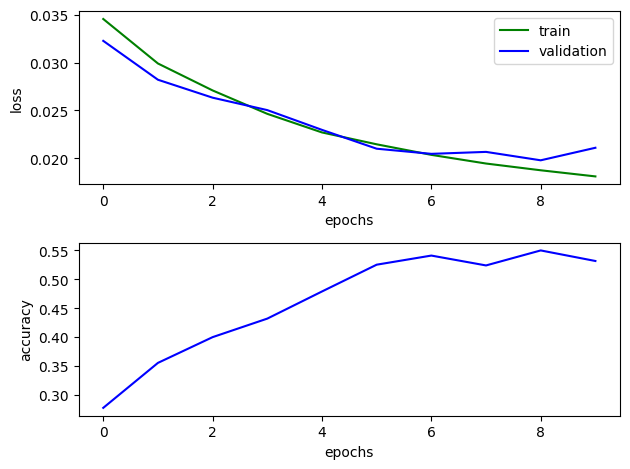

In [5]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(train_losses, color="green", label="train")
plt.plot(val_losses, color="blue", label="validation")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(2, 1, 2)
plt.plot(accuracies, color="blue")
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.tight_layout()

Let's try to save the model and load it again, and check that the loaded model behaves exactly as the previously-saved one.

In [6]:
model_path = 'cifar_model.pt'
torch.save(net.state_dict(), model_path)

In [7]:
new_model = Net()
new_model.load_state_dict(torch.load(model_path))

new_model.eval()
val_loss, accuracy = valid_epoch(new_model, val_loader, loss_fn)
print("accuracy of the loaded model: ", accuracy)

accuracy of the loaded model:  0.5317999720573425


## Helping our model to converge and generalize: Regularization

The tools aimed at easing generalization are usually referred to as **generalization**.

* The first way to stabilize generalization is to add a regularization term to the loss. This makes the loss have a smoother topography, and there’s relatively less to gain from fitting individual samples. We can add weight penalty either by encapsulating the norm in the loss (and use autograd on it), or by adding `weight_decay` in the optimizer.

$$L(\mathbf{x}, y; \boldsymbol{\theta})  + \lambda ||\boldsymbol{\theta}||_p$$

* Another way is to use dropout: zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration, giving neurons in the model less chance to coordinate in the memorization process that happens during overfitting. In PyTorch, we can implement dropout in a model by adding an `nn.Dropout` module, in which we specify the **probability** with which inputs will be zeroed out. Note that dropout is normally active **during training**, while during the evaluation of a trained model in production, dropout is bypassed or, equivalently, assigned a probability equal to zero.

* Finally, we can keep the activations in check with batch normalization: we rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution, avoiding the inputs to activation functions being too far into the saturated portion of the function, as they risk killing gradients and slowing training. Just as for dropout, batch normalization needs to behave differently during training and inference. In fact, at inference time, we want to avoid having the output for a specific input depend on the statistics of the other inputs we're presenting to the model.

We finally know what the `model.train()` and `model.eval()` are for. In the case of dropout, the `model.eval()` assigns a zero probability of dropout for the model's neurons.


In [8]:
from collections import OrderedDict

class SmallCNN(nn.Module):
    def __init__(self, drop=0.5):
        super(SmallCNN, self).__init__()
        self.num_channels = 3
        self.num_labels = 10
        activ = nn.ReLU(True)
        self.feature_extractor = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.num_channels, 32, 3)),
            ('relu1', activ),
            ('conv2', nn.Conv2d(32, 32, 3)),
            ('relu2', activ),
            ('maxpool1', nn.MaxPool2d(2, 2)),
            ('conv3', nn.Conv2d(32, 64, 3)),
            ('relu3', activ),
            ('conv4', nn.Conv2d(64, 64, 3)),
            ('relu4', activ),
            ('maxpool2', nn.MaxPool2d(2, 2)),
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(64 * 4 * 4, 200)),
            ('relu1', activ),
            ('drop', nn.Dropout(drop)),
            ('fc2', nn.Linear(200, 200)),
            ('relu2', activ),
            ('fc3', nn.Linear(200, self.num_labels)),
        ]))

    def forward(self, input):
        features = self.feature_extractor(input)
        logits = self.classifier(features.view(-1, 64 * 4 * 4))
        return logits
    
net = SmallCNN()
learning_rate = 1e-2
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net()
net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
loss_fn = torch.nn.CrossEntropyLoss()


train_losses, val_losses, accuracies = [], [], []
for epoch in range(epochs):
    train_loss = train_epoch(net, train_loader, optimizer, scheduler, loss_fn)
    val_loss, accuracy = valid_epoch(net, val_loader, loss_fn)
    print(f"epoch: {epoch}, validation accuracy: {accuracy}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)

epoch: 0, validation accuracy: 0.36340001225471497
epoch: 1, validation accuracy: 0.4239000082015991
epoch: 2, validation accuracy: 0.489300012588501
epoch: 3, validation accuracy: 0.5117999911308289
epoch: 4, validation accuracy: 0.513700008392334
epoch: 5, validation accuracy: 0.52920001745224
epoch: 6, validation accuracy: 0.5471000075340271
epoch: 7, validation accuracy: 0.5602999925613403
epoch: 8, validation accuracy: 0.5658000111579895
epoch: 9, validation accuracy: 0.5702000260353088


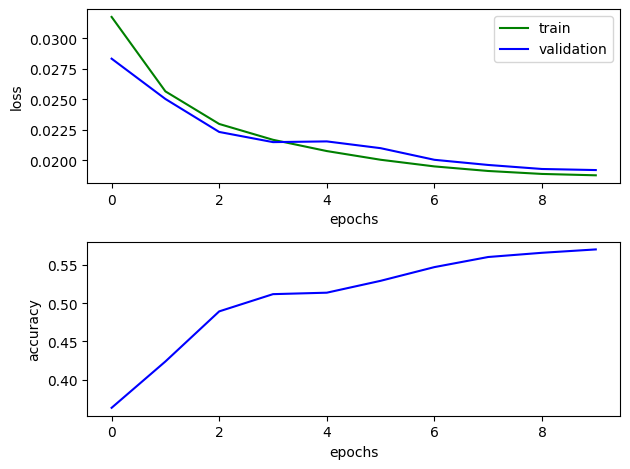

In [9]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(train_losses, color="green", label="train")
plt.plot(val_losses, color="blue", label="validation")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(2, 1, 2)
plt.plot(accuracies, color="blue")
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.tight_layout()

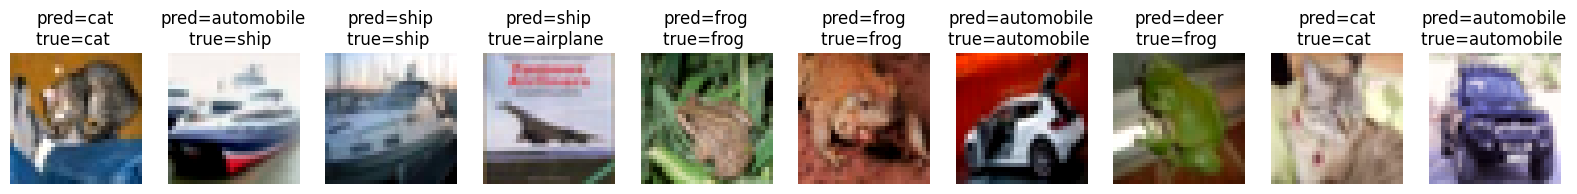

In [10]:
def imshow(t, title=None):
    """Display image for Tensor."""
    t = t.numpy().transpose((1, 2, 0))
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    t = std * t + mean
    t = torch.clip(t, 0, 1)
    plt.axis("off") 
    plt.imshow(t)

    if title is not None:
        plt.title(title)

images, labels = next(iter(val_loader))
cifar_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]  
num_images = 10
fig = plt.figure(figsize=(2*num_images, 2))
for i, (image, label) in enumerate(zip(images, labels)):
    if i == num_images:
        break
    pred = net(image).argmax(dim=1)
    fig.add_subplot(1, num_images, i+1)
    imshow(image, title=f"pred={cifar_labels[pred]}\ntrue={cifar_labels[label]} ")

